In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from CV.preprocessing.ImageToArrayPreprocessor import ImageToArrayPreprocessor
from CV.preprocessing.aspectawarepreprocessor import AspectAwarePreprocessor
from CV.datasets.SimpleDatasetLoader import SimpleDatasetLoader
from CV.nn.conv.fcheadnet import FCHeadNet
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model
from imutils import paths
import numpy as np
import argparse
import os
#我再
'''aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                        horizontal_flip=True, fill_mode="nearest")'''

# grab the list of images that we’ll be describing, then extract
# the class label names from the image paths
print("[INFO] loading images...")
imagePaths = list(paths.list_images("data3"))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

# initialize the image preprocessors
aap = AspectAwarePreprocessor(128,128)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities to
# the range [0, 1]

sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
(data, labels) = sdl.load(imagePaths, verbose = 500)
data = data.astype("float")/255.0

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.1, random_state=42)

#convert the labels from integers to vectors
#trainY = LabelBinarizer().fit_transform(trainY)
#testY = LabelBinarizer().fit_transform(testY)

from keras.utils import to_categorical
lb = LabelBinarizer()
#train_y = lb.fit_transform(train_y)
#test_y = lb.fit_transform(test_y)
lb.fit(trainY)
trainY=lb.transform(trainY)
testY = lb.transform(testY)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

# load the VGG16 network, ensuring the head FC layer sets are left
# off

#baseModel = VGG16(weights="imagenet", include_top=False,
#                 input_tensor=Input(shape=(128,128,3)))
baseModel = ResNet50(weights="imagenet", include_top=False)

# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(baseModel, len(classNames),256)

# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=baseModel.input, output = headModel)

# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False
    
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = RMSprop(lr=0.001)
model.compile(loss="categorical_crossentropy",optimizer=opt,
             metrics=["accuracy"])

# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
'''model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
    validation_data=(testX, testY), epochs=25,
    steps_per_epoch=len(trainX) // 32, verbose=1)'''
model.fit(trainX, trainY, batch_size=32,
    validation_data=(testX, testY), epochs=25,
     verbose=1)
# evaluate the network after initialization
print("[INFO] evaluating after initialization...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                           predictions.argmax(axis=1),target_names=classNames))


# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
    layer.trainable = True
# 用小lr的sgd重新finetune
print("[INFO] re-compile model...")
opt = SGD(lr = 0.001)
model.compile(loss="categorical_crossentropy", optimizer = opt,
             metrics=["accuracy"])

print("[INFO] fine-tuning model...")
model.fit(trainX, trainY, batch_size=32,
    validation_data=(testX, testY), epochs=25,
     verbose=1)

# evaluate the network after fine-tune
print("[INFO] evaluating after initialization...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                           predictions.argmax(axis=1),target_names=classNames))

# save the model to disk
print("[INFO] serializing model...")
model.save("flowers17.model")

[INFO] re-compile model...
[INFO] fine-tuning model...
Train on 4374 samples, validate on 1458 samples
Epoch 1/10
4374/4374 [==============================] - 438s 100ms/step - loss: 0.0565 - acc: 0.9781 - val_loss: 0.6080 - val_acc: 0.8615
Epoch 2/10
4374/4374 [==============================] - 445s 102ms/step - loss: 0.0519 - acc: 0.9815 - val_loss: 0.6006 - val_acc: 0.8587
Epoch 3/10
4374/4374 [==============================] - 437s 100ms/step - loss: 0.0507 - acc: 0.9824 - val_loss: 0.6611 - val_acc: 0.8601
Epoch 4/10
4374/4374 [==============================] - 441s 101ms/step - loss: 0.1567 - acc: 0.9417 - val_loss: 0.6387 - val_acc: 0.8505
Epoch 5/10
4374/4374 [==============================] - 445s 102ms/step - loss: 0.0478 - acc: 0.9835 - val_loss: 0.5398 - val_acc: 0.8635
Epoch 6/10
4374/4374 [==============================] - 445s 102ms/step - loss: 0.0572 - acc: 0.9806 - val_loss: 0.6420 - val_acc: 0.8628
Epoch 7/10
4374/4374 [==============================] - 437s 100ms/st

ValueError: x and y must have same first dimension, but have shapes (25,) and (10,)

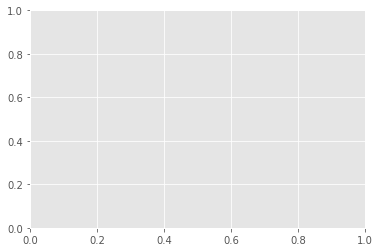

In [14]:
EPOCHS =15
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
    layer.trainable = True
# 用小lr的sgd重新finetune
print("[INFO] re-compile model...")
opt = SGD(lr = 0.001)
#opt = SGD(lr=0.01, decay=0.05/20, momentum=0.9,nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer = opt,
             metrics=["accuracy"])

print("[INFO] fine-tuning model...")
H = model.fit(trainX, trainY, batch_size=32,
    validation_data=(testX, testY), epochs=EPOCHS,
     verbose=1)

# evaluate the network after fine-tune
print("[INFO] evaluating after initialization...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                           predictions.argmax(axis=1),target_names=classNames))

# save the model to disk
print("[INFO] serializing model...")
model.save("flowers17.model")

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_acc"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [12]:

##### import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), model.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), model.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 25),model.history["acc"], label="train_acc")
plt.plot(np.arange(0, 25), model.history["val_acc"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

TypeError: 'History' object is not subscriptable

<Figure size 432x288 with 0 Axes>

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [4]:
dict([(layer.name, layer) for layer in model.layers[1:]])

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x23f200fe780>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x23f201862b0>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x23f20186e10>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x23f200fef60>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x23f2019a710>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x23f45aa9320>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x23f45ac29b0>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x23ff0f77630>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x23ff0f688d0>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x23ff0fa0f28>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x23ff0fb18d0>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x23ff0fe0828>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x23ff0fcaf98>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x23ff0ff3f98>,
 'block5_c

In [6]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.
This script can run on CPU in a few minutes.
Results example: http://i.imgur.com/4nj4KjN.jpg
'''
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv3'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# build the VGG16 network with ImageNet weights
print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))
    


Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0      

Current loss value: 64.536865
Current loss value: 75.07038
Current loss value: 90.27225
Current loss value: 102.85107
Current loss value: 115.09915
Current loss value: 126.05972
Current loss value: 138.03796
Current loss value: 146.00037
Current loss value: 166.05855
Current loss value: 174.75084
Current loss value: 183.13806
Current loss value: 198.24211
Current loss value: 207.18103
Current loss value: 220.72537
Current loss value: 232.703
Current loss value: 245.98196
Filter 42 processed in 4s
Processing filter 43
Current loss value: 0.0
Filter 43 processed in 0s
Processing filter 44
Current loss value: 0.0
Filter 44 processed in 0s
Processing filter 45
Current loss value: 0.43614185
Current loss value: 0.9358306
Current loss value: 8.856112
Current loss value: 12.673282
Current loss value: 24.299694
Current loss value: 38.37829
Current loss value: 48.7965
Current loss value: 67.15813
Current loss value: 95.87837
Current loss value: 121.2885
Current loss value: 154.53302
Current los

Current loss value: 0.0
Filter 87 processed in 1s
Processing filter 88
Current loss value: 0.0
Filter 88 processed in 1s
Processing filter 89
Current loss value: 0.0
Filter 89 processed in 1s
Processing filter 90
Current loss value: 0.0
Filter 90 processed in 1s
Processing filter 91
Current loss value: 0.0
Filter 91 processed in 1s
Processing filter 92
Current loss value: 0.0
Filter 92 processed in 1s
Processing filter 93
Current loss value: 0.0
Filter 93 processed in 1s
Processing filter 94
Current loss value: 0.0
Filter 94 processed in 1s
Processing filter 95
Current loss value: 0.0
Filter 95 processed in 1s
Processing filter 96
Current loss value: 0.0
Filter 96 processed in 1s
Processing filter 97
Current loss value: 0.0
Filter 97 processed in 1s
Processing filter 98
Current loss value: 0.0
Filter 98 processed in 1s
Processing filter 99
Current loss value: 0.00046803989
Current loss value: 1.6038191
Current loss value: 7.564179
Current loss value: 27.099327
Current loss value: 50.28

Current loss value: 358.68787
Current loss value: 400.8246
Current loss value: 439.79663
Current loss value: 484.33502
Current loss value: 503.20776
Current loss value: 542.05194
Current loss value: 565.77966
Current loss value: 602.8788
Current loss value: 627.7487
Current loss value: 663.0447
Filter 149 processed in 4s
Processing filter 150
Current loss value: 0.0
Filter 150 processed in 1s
Processing filter 151
Current loss value: 0.0
Filter 151 processed in 1s
Processing filter 152
Current loss value: 0.0
Filter 152 processed in 1s
Processing filter 153
Current loss value: 0.0
Filter 153 processed in 1s
Processing filter 154
Current loss value: 0.0
Filter 154 processed in 1s
Processing filter 155
Current loss value: 0.0
Filter 155 processed in 1s
Processing filter 156
Current loss value: 0.0
Filter 156 processed in 1s
Processing filter 157
Current loss value: 0.06563922
Current loss value: 0.41332257
Current loss value: 5.8655915
Current loss value: 17.76541
Current loss value: 43.

IndexError: list index out of range

In [9]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 4

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin =5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('128stitched_filters_%dx%d.png' % (n, n), stitched_filters)

C:\Users\HOU\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
